In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
month_day_fmt = mdates.DateFormatter('%m/%d')

In [3]:
day_df = pd.read_pickle('day.pkl')
total_df = pd.read_pickle('total.pkl')

# Folkhälsomyndigheten states that data is incomplete for last 2 days, remove those along with 'unknown data'
day_complete_df = day_df[:-3]

### Population is fetched from [SCB](http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101A/BefolkningR1860)

In [4]:
pop_2019 = pd.read_pickle('external/pop_2019.pkl')
pop_agegroup = pop_2019.groupby('agegroup')['value'].sum()
pop_sex = pop_2019.groupby('sex')['value'].sum()

In [5]:
pop_sex

sex
kvinnor    5131775
män        5195814
Name: value, dtype: int64

In [6]:
male_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Man', 'total_cases']/pop_sex[1]
female_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Kvinna', 'total_cases']/pop_sex[0]
total_df.loc[total_df.sex == 'Man', 'cases_per_100k'] = male_per_100k
total_df.loc[total_df.sex == 'Kvinna', 'cases_per_100k'] = female_per_100k

In [7]:
total_df.loc[total_df.agegroup == '80-90', 'agegroup'] = '80-89'
agegroup_rows = total_df[total_df.agegroup.notna()]
age_cases_per_100k = 1000 * 100 * agegroup_rows.total_cases[:-1]/pop_agegroup.to_numpy()
age_cases_per_100k
total_df.loc[total_df.agegroup.notna(), 'cases_per_100k'] = age_cases_per_100k

In [8]:
age_df = total_df.loc[total_df.agegroup.notna(),total_df.columns[2:]]
age_df['cases_percentage'] = age_df['cases_per_100k']/1000
age_df['deceased_percentage'] = 100 * age_df['total_deceased']/age_df['total_cases']
age_df

,agegroup,total_cases,cases_per_100k,total_icu,total_deceased,cases_percentage,deceased_percentage
0,0-9,53,3.923894,1,0,0.003924,0.000000
1,10-19,153,13.080881,0,0,0.013081,0.000000
2,20-29,666,48.947482,28,3,0.048947,0.450450
3,30-39,848,63.092140,32,1,0.063092,0.117925
4,40-49,1193,91.846311,81,4,0.091846,0.335289
5,50-59,1582,123.123955,182,31,0.123124,1.959545
6,60-69,1272,115.118748,217,57,0.115119,4.481132
7,70-79,1303,138.206372,151,203,0.138206,15.579432
8,80-89,1357,345.444687,26,325,0.345445,23.949889
9,90+,704,900.520613,1,169,0.900521,24.005682


In [9]:
print(f'Procentuell andel positivt testade: {day_df.total_cases.sum()/pop_agegroup.sum():.3}')

Procentuell andel positivt testade: 0.000885


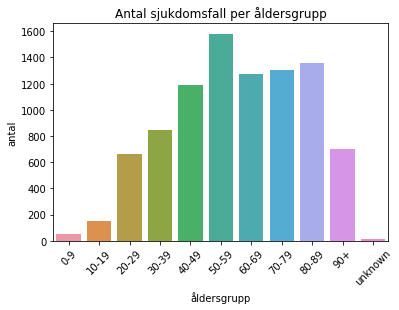

In [10]:
ax = sns.barplot('agegroup', 'total_cases', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal')

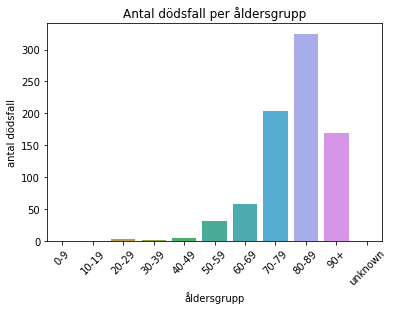

In [11]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal dödsfall')

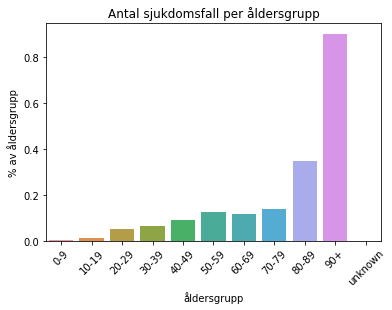

In [12]:
ax = sns.barplot('agegroup', 'cases_percentage', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='% av åldersgrupp')

In [13]:
def autolabel_above(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [14]:
def autolabel_beside(rects):
    """Attach a text label to the right of each bar in *rects*, displaying its width."""
    for rect in rects:
        width = int(rect.get_width())
        ax.annotate('{}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(5, -5),
                    textcoords="offset points",
                    ha='center', va='bottom')

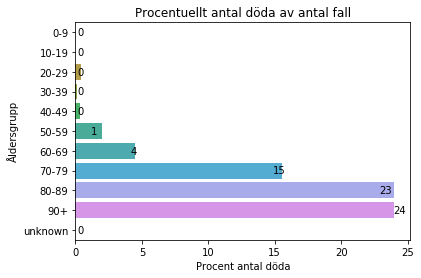

In [15]:
ax = sns.barplot('deceased_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal döda av antal fall', xlabel='Procent antal döda', ylabel='Åldersgrupp')

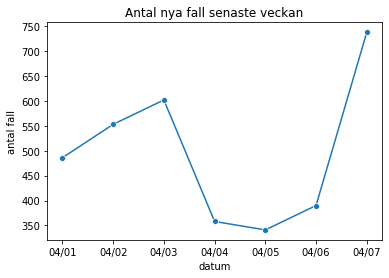

In [16]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan', xlabel='datum', ylabel='antal fall')

[Text(0, 0.5, 'antal fall'),
 Text(0.5, 0, 'datum'),
 Text(0.5, 1.0, 'Antal nya fall senaste månaden')]

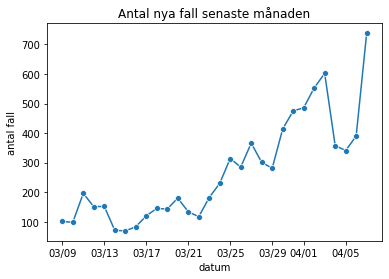

In [17]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-30:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste månaden', xlabel='datum', ylabel='antal fall')

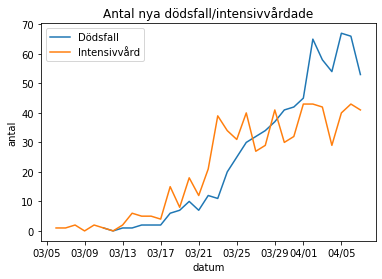

In [18]:
sns.lineplot('date', 'total_deceased', data=day_complete_df)
ax = sns.lineplot('date', 'total_icu', data=day_complete_df)
ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya dödsfall/intensivvårdade', xlabel='datum', ylabel='antal')
_ = ax.legend(['Dödsfall', 'Intensivvård'])